#1. Import Relevant Libraries

In [34]:
import pandas as pd
from pandas import read_csv
import numpy as np

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from keras.utils.vis_utils import plot_model

#2. Upload Files to Google Colab

This section of code uploads the communities.csv dataset.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving communities.csv to communities.csv


This section of code uploads the attributes of the communities.csv dataset.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving attributes.csv to attributes.csv


In [4]:
attrib = read_csv('attributes.csv', delim_whitespace = True)

Here, we read the communities.csv dataset and combine it with the attributes from the attributes.csv.

In [5]:
data = read_csv('communities.csv', names = attrib['attributes'], sep = ';')

The final combination looks as follows:

In [ ]:
data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


#3. Data Preprocessing

In [6]:
print(data.dtypes)

state                    int64
county                  object
community               object
communityname           object
fold                     int64
                        ...   
LemasPctPolicOnPatr     object
LemasGangUnitDeploy     object
LemasPctOfficDrugUn    float64
PolicBudgPerPop         object
ViolentCrimesPerPop    float64
Length: 128, dtype: object


There are several attributes within the communities dataset that do not contain predictive values. 

These attributes include:
* state
* county
* community
* communityname
* fold

As such, we can drop them instead. 

In [7]:
data = data.drop(columns=['state','county', 'community','communityname', 'fold'], axis=1)

The dataset after the columns above are dropped shall be as follows:

In [8]:
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


Since the dataset contains "?", it is read as a valid value when they are actually a missing value.

Therefore, we change the value of "?" to a proper representation of a missing value with np.nan, where "?" will be replaced with "NaN".

In [9]:
data = data.replace('?', np.nan)

We can now calculate the missing values for each attribute.

From the code below, we can see that an attribute is supposed to have 1994 values.

In [10]:
print(data.count())

population             1994
householdsize          1994
racepctblack           1994
racePctWhite           1994
racePctAsian           1994
                       ... 
LemasPctPolicOnPatr     319
LemasGangUnitDeploy     319
LemasPctOfficDrugUn    1994
PolicBudgPerPop         319
ViolentCrimesPerPop    1994
Length: 123, dtype: int64


There are several attributes that are missing lots of values.

In [11]:
attr_missing_values = data.columns[data.isnull().any()] 
print(attr_missing_values)

Index(['OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
       'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop',
       'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian',
       'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
       'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object')


We can find these attributes with missing values and store them in a variable called _attr_missing_values_. 

In [12]:
data[attr_missing_values].describe()

,OtherPerCap,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop
count,1993,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319
unique,97,38,52,34,55,44,59,75,52,76,74,73,54,50,72,30,15,77,63,38,72,3,51
top,0,0.02,0.1,0.98,0.19,0.02,0.14,0.23,0.1,0.78,0.97,0,0,0,0.07,0.03,0.57,0.19,0.02,0.02,0.84,0,0.12
freq,129,80,19,81,17,55,23,15,19,12,11,23,72,189,14,48,54,12,27,69,13,126,22


We can see that the attribute OtherPerCap is only missing 1 value (1993 out of 1994), and the rest only contain 319 values out of 1994.

Therefore, we can impute the missing value of OtherPerCap. We will then drop the remaining attributes from attr_missing_values as they contain too many missing values.


In [13]:
data['OtherPerCap'].fillna(data['OtherPerCap'].median(skipna=True), inplace=True)

In [14]:
data = data.dropna(axis=1)


We will impute the missing value with the median data of the value from the attribute 'OtherPerCap'.

In [15]:
data['OtherPerCap'] = np.asarray(data['OtherPerCap']).astype(np.float64)

We can then check the amount of values of 'OtherPerCap', which should be 1994.

In [16]:
data['OtherPerCap'].describe()

count    1994.000000
mean        0.284724
std         0.190962
min         0.000000
25%         0.170000
50%         0.250000
75%         0.360000
max         1.000000
Name: OtherPerCap, dtype: float64

In [17]:
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.01,0.97,0.96,0.60,0.47,0.52,0.11,0.11,0.24,0.21,0.19,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.05,0.16,0.19,0.59,0.60,0.37,0.89,0.02,0.19,0.5,0.01,0.89,0.87,0.04,0.55,0.73,0.05,0.14,0.31,0.31,0.30,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


#4. Regression Task

We can now move to the task of predicting the value of Violent Crimes per Population from the communities dataset.

We will first randomly split the dataset for the training and testing process.

In [18]:
dataset = data.copy()

In [29]:
X = data.iloc[:, 0:100].values
y = data.iloc[:, 100].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

print(X.shape)
print(y.shape)

(1994, 100)
(1994,)


Let's define the first model.

Let's have the 1st model with the following configuration:

*   1 Hidden Layer with 10 nodes
*   ReLu activation function
*   Adam Optimizer
*   1 batch size
*   10 epochs









In [ ]:
model_1 = Sequential()
model_1.add(Dense(10, input_dim=100, activation='relu'))
model_1.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_1.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_1.fit(X_train, y_train, batch_size = 1, epochs = 10, verbose=0)

pred_train_1 = model_1.predict(X_train)
pred_test_1 = model_1.predict(X_test)

print("Model 1 MSE: ", mean_squared_error(y_test, pred_test_1))

Model 1 MSE:  0.019446853467321633


Considering the ViolentCrimesPerPop values are at the range of 0 to 1, the MSE of 0.019 is quite okay.

Let's try increasing the number of nodes in the Hidden Layer to 50.

In [ ]:
model_2 = Sequential()
model_2.add(Dense(50, input_dim=100, activation='relu'))
model_2.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_2.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_2.fit(X_train, y_train, batch_size = 1, epochs = 10, verbose=0)

pred_train_2 = model_2.predict(X_train)
predicted_y_2 = model_2.predict(X_test)

print("Model 2 MSE: ", mean_squared_error(y_test, predicted_y_2))

Model 2 MSE:  0.018278420430347494


With the nodes in the Hidden Layer increased to 50, we reduced the MSE to 0.018.

Let's try adding 25 more nodes to the Hidden Layer.

In [ ]:
model_3 = Sequential()
model_3.add(Dense(75, input_dim=100, activation='relu'))
model_3.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_3.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_3.fit(X_train, y_train, batch_size = 1, epochs = 10, verbose=0)

pred_train_3 = model_3.predict(X_train)
predicted_y_3 = model_3.predict(X_test)

print("Model 3 MSE: ", mean_squared_error(y_test, predicted_y_3))

Model 3 MSE:  0.020469206060345815


With 75 nodes in the Hidden Layer our MSE has actually increased to 0.02. 

Seems like 50 nodes is the best value in the first Hidden Layer so far.

Now let's try adding more Hidden Layers in our model.

In [ ]:
model_4 = Sequential()
model_4.add(Dense(50, input_dim=100, activation='relu'))
model_4.add(Dense(50, activation='relu'))
model_4.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_4.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_4.fit(X_train, y_train, batch_size = 1, epochs = 10, verbose=0)

pred_train_4 = model_4.predict(X_train)
predicted_y_4 = model_4.predict(X_test)

print("Model 4 MSE: ", mean_squared_error(y_test, predicted_y_4))

Model 4 MSE:  0.018794383570859864


With 2 Hidden Layers, each with 50 nodes, our MSE has reduced to 0.18. Let's try reducing the nodes in the 2nd Hidden Layer

In [ ]:
model_5 = Sequential()
model_5.add(Dense(50, input_dim=100, activation='relu'))
model_5.add(Dense(25, activation='relu'))
model_5.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_5.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_5.fit(X_train, y_train, batch_size = 1, epochs = 10, verbose=0)

pred_train_5 = model_5.predict(X_train)
predicted_y_5 = model_5.predict(X_test)

print("Model 5 MSE: ", mean_squared_error(y_test, predicted_y_5))

Model 5 MSE:  0.01827463807331326


With 50 nodes in the 1st HL and 25 in the 2nd HL, we have gained an MSE of 0.182, the best so far.

# Batch Size Value Experimentation

Now let's try experimenting with the batch_size and epochs.

Let's try increasing the batch size to 50.

In [ ]:
model_6 = Sequential()
model_6.add(Dense(50, input_dim=100, activation='relu'))
model_6.add(Dense(25, activation='relu'))
model_6.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_6.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_6.fit(X_train, y_train, batch_size = 50, epochs = 10, verbose=0)

pred_train_6 = model_6.predict(X_train)
predicted_y_6 = model_6.predict(X_test)

print("Model 6 MSE: ", mean_squared_error(y_test, predicted_y_6))

Model 6 MSE:  0.01922983920763258


The model has yielded 0.024 MSE. Perhaps the model was learning too quickly.

Let's try reducing the batch size to 50.

In [ ]:
model_7 = Sequential()
model_7.add(Dense(50, input_dim=100, activation='relu'))
model_7.add(Dense(25, activation='relu'))
model_7.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_7.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_7.fit(X_train, y_train, batch_size = 75, epochs = 10, verbose=0)

pred_train_7 = model_7.predict(X_train)
predicted_y_7 = model_7.predict(X_test)

print("Model 7 MSE: ", mean_squared_error(y_test, predicted_y_7))

Model 7 MSE:  0.018611213439503352


In [ ]:
model_8 = Sequential()
model_8.add(Dense(50, input_dim=100, activation='relu'))
model_8.add(Dense(25, activation='relu'))
model_8.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_8.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_8.fit(X_train, y_train, batch_size = 100, epochs = 10, verbose=0)

pred_train_8 = model_8.predict(X_train)
predicted_y_8 = model_8.predict(X_test)

print("Model 8 MSE: ", mean_squared_error(y_test, predicted_y_8))

Model 8 MSE:  0.019692743721413004


And agai, the model has performed worse. It seems that a high batch size is not viable for this case.

Let's try tuning it down to 5.

In [ ]:
model_8 = Sequential()
model_8.add(Dense(50, input_dim=100, activation='relu'))
model_8.add(Dense(25, activation='relu'))
model_8.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_8.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_8.fit(X_train, y_train, batch_size = 5, epochs = 10, verbose=0)

pred_train_8 = model_8.predict(X_train)
predicted_y_8 = model_8.predict(X_test)

print("Model 8 MSE: ", mean_squared_error(y_test, predicted_y_8))

Model 8 MSE:  0.018686361001895736


The model has yielded a quite performance of 0.0186 MSE.

Let's try reducing it again to 3.

In [ ]:
model_9 = Sequential()
model_9.add(Dense(50, input_dim=100, activation='relu'))
model_9.add(Dense(25, activation='relu'))
model_9.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_9.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_9.fit(X_train, y_train, batch_size = 3, epochs = 10, verbose=0)

pred_train_9 = model_9.predict(X_train)
predicted_y_9 = model_9.predict(X_test)

print("Model 9 MSE: ", mean_squared_error(y_test, predicted_y_9))

Model 9 MSE:  0.018593758353298746


The model has yielded the one the best performance so far at 0.01859 MSE.

It seems that the optimal range of batch size is 1 - 5.

# Epoch Value Experimentation

Now let's try experimenting with the value of epoch.

In [ ]:
model_10 = Sequential()
model_10.add(Dense(50, input_dim=100, activation='relu'))
model_10.add(Dense(25, activation='relu'))
model_10.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_10.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_10.fit(X_train, y_train, batch_size = 3, epochs = 50, verbose=0)

pred_train_10 = model_10.predict(X_train)
predicted_y_10 = model_10.predict(X_test)

print("Model 10 MSE: ", mean_squared_error(y_test, predicted_y_10))

Model 10 MSE:  0.020698697809559963


In [ ]:
model_11 = Sequential()
model_11.add(Dense(50, input_dim=100, activation='relu'))
model_11.add(Dense(25, activation='relu'))
model_11.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_11.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_11.fit(X_train, y_train, batch_size = 3, epochs = 100, verbose=0)

pred_train_11 = model_11.predict(X_train)
predicted_y_11 = model_11.predict(X_test)

print("Model 11 MSE: ", mean_squared_error(y_test, predicted_y_11))

Model 11 MSE:  0.024563161454921264


It seems that a high epoch number is not viable for our case, as it has yielded a high MSE of 0.245, when compared to our previous results.

Let's keep it at 10.

# Hidden Layer Experimentation

Let's try experimenting with more Hidden Layers now.
Let's try adding 1 more Hidden Layer with 10 nodes.

In [ ]:
model_12 = Sequential()
model_12.add(Dense(50, input_dim=100, activation='relu'))
model_12.add(Dense(25, activation='relu'))
model_12.add(Dense(10, activation='relu'))
model_12.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_12.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_12.fit(X_train, y_train, batch_size = 3, epochs = 10, verbose=0)

pred_train_12 = model_12.predict(X_train)
predicted_y_12 = model_12.predict(X_test)

print("Model 12 MSE: ", mean_squared_error(y_test, predicted_y_12))

Model 12 MSE:  0.01815367035511721


With the addition of another Hidden Layer with 10 nodes, we have gained the best performance so far with 0.1815 MSE.

Let's try reducing the node of the 3rd Hidden Layer to 5.

In [ ]:
model_13 = Sequential()
model_13.add(Dense(50, input_dim=100, activation='relu'))
model_13.add(Dense(25, activation='relu'))
model_13.add(Dense(5, activation='relu'))
model_13.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_13.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_13.fit(X_train, y_train, batch_size = 3, epochs = 10, verbose=0)

pred_train_13 = model_13.predict(X_train)
predicted_y_13 = model_13.predict(X_test)

print("Model 12 MSE: ", mean_squared_error(y_test, predicted_y_13))

Model 12 MSE:  0.018655000940964145


We have gained a good performance, but it seems 10 nodes in the 3rd Hidden Layer was better. Let's keep the value at that for now.

Let's try adding another Hidden Layer, a total of 3 now.
Let's add 5 nodes to that new Hidden Layer.

In [ ]:
model_14 = Sequential()
model_14.add(Dense(50, input_dim=100, activation='relu'))
model_14.add(Dense(25, activation='relu'))
model_14.add(Dense(10, activation='relu'))
model_14.add(Dense(5, activation='relu'))
model_14.add(Dense(1, kernel_initializer='normal'))

# Compile model
model_14.compile(loss='mean_squared_error', optimizer='adam')

# evaluate model
model_14.fit(X_train, y_train, batch_size = 3, epochs = 10, verbose=0)

pred_train_14 = model_14.predict(X_train)
predicted_y_14 = model_14.predict(X_test)

print("Model 14 MSE: ", mean_squared_error(y_test, predicted_y_14))

Model 14 MSE:  0.05214890060385184


With the addition of the 4th Hidden Layer, we have gained the worst performance so far. 

According to our results above, 2 Hidden Layers seem to be the best value so far.

# Regression Task Conclusions

With the results of our experimentations of the Regression Task, we can form some conclusions about the parameters and its values to gain the best performing model.

1.   **Number of Hidden Layers and number of its nodes** 
* Based on our experiments, the model with best peformance had 3 Hidden Layers: 1st layer with 50 nodes, 2nd layer with 25, and 3rd layer with 10 nodes.

2.   **Number of Epochs**
* Based on our experiments, the model with best peformance had 10 epochs. In general, based on our experiments, the higher the epoch, the worse the performance. This is perhaps due to the model overfitting the data.

3. **Number of Batch Size**
* Based on our experiments, the model with best peformance had a batch size of 3. In general, based on our experiments, the higher the batch size, the worse the performance, similar to epoch. Again, this is perhaps due to the model overfitting the data.

Based on our experiments, the best value range for each parameters are:

* **Number of Hidden Layers**: 2 - 3
* **Nodes in a Hidden Layer**: 10 - 50
* **Number of Epochs**: 10 - 20
* **Number of Batch Size**: 1 - 10


#5. Classification Task

For the Classification Task, let's begin by making a duplicate of the preprocessed data to a new Pandas Dataframe called 'dataset' as follows.

In [ ]:
dataset = data.copy()

Now let's make the classification class by creating a new class based on the values of the 'ViolentCrimesPerPop' attribute.

We'll assign the class of the attribute to 'Low' if the 
value is lower or equals to 0.3; 'Medium' if it is between 0.31 to 0.6; and 'High' if it is above 0.61.


*  'Low' = value < 0.3 
*  'Medium' = 0.31 <= value <= 0.6 
* 'High' = >= 0.61



In [19]:
for i in range (0, len(dataset.ViolentCrimesPerPop)):
  if dataset['ViolentCrimesPerPop'][i] <= 0.3:
    dataset.ViolentCrimesPerPop[i] = 'Low'
  elif dataset['ViolentCrimesPerPop'][i] > 0.3 and dataset['ViolentCrimesPerPop'][i] <= 0.6:
    dataset.ViolentCrimesPerPop[i] = 'Medium'
  elif dataset['ViolentCrimesPerPop'][i] > 0.6:
    dataset.ViolentCrimesPerPop[i] = 'High'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Now let's One Hot Encode the classes of 'Low', 'Medium', and 'High'. 


In [20]:
enc_data = pd.get_dummies(dataset[['ViolentCrimesPerPop']])
res = pd.concat([dataset, enc_data], axis=1)
res = res.drop(['ViolentCrimesPerPop'], axis=1)

In [21]:
X_c = res.iloc[:, 0:100].values
y_c = res.iloc[:, 100:103].values

X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size = 0.3, random_state = 1)

print(X_c.shape)
print(y_c.shape)

(1994, 100)
(1994, 3)


# Hidden Layer Experimentation

Let's begin by creating a Baseline Model by adding 1 Hidden Layer with 50 nodes.


In [ ]:
# define the keras model
cmodel_1 = Sequential()
cmodel_1.add(Dense(50, input_dim=100, activation='relu'))
cmodel_1.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_1.fit(X_c, y_c, epochs=50, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_1 = cmodel_1.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_1*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.8250
Training Accuracy: 82.50 %


With only 1 Hidden Layer with 50 nodes, we have gained an accuracy of 82.50%. Pretty good.

Let's try increasing the nodes to 75.

In [ ]:
# define the keras model
cmodel_2 = Sequential()
cmodel_2.add(Dense(75, input_dim=100, activation='relu'))
cmodel_2.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_2.fit(X_c, y_c, epochs=50, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_2 = cmodel_2.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_2*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.3318 - accuracy: 0.8701
Training Accuracy: 87.01 %


It seems that our accuracy has increased to 87.01%. 

Let's try increasing the nodes to 100.

In [ ]:
# define the keras model
cmodel_3 = Sequential()
cmodel_3.add(Dense(100, input_dim=100, activation='relu'))
cmodel_3.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_3.fit(X_c, y_c, epochs=50, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_3 = cmodel_3.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_3*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.3231 - accuracy: 0.8731
Training Accuracy: 87.31 %


Having 100 nodes in the 1st Hidden Layer has yielded the best accuracy so far, reaching 87.31%.

It seems that around 50-100 is the sweet spot for the nodes in the 1st Hidden Layer.

Let's try adding another Hidden Layer with 100 nodes.

In [ ]:
# define the keras model
cmodel_4 = Sequential()
cmodel_4.add(Dense(100, input_dim=100, activation='relu'))
cmodel_4.add(Dense(100, activation='relu'))
cmodel_4.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_4.fit(X_c, y_c, epochs=50, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_4 = cmodel_4.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_4*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.1993 - accuracy: 0.9238
Training Accuracy: 92.38 %


The model with a second Hidden Layer with 100 nodes has achieved the highest accuracy so far, at 92.38% 

Let's try 75 nodes in the 2nd Hidden Layer.

In [ ]:
# define the keras model
cmodel_5 = Sequential()
cmodel_5.add(Dense(100, input_dim=100, activation='relu'))
cmodel_5.add(Dense(75, activation='relu'))
cmodel_5.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_5.fit(X_c, y_c, epochs=50, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_5 = cmodel_5.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_5*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.2087 - accuracy: 0.9313
Training Accuracy: 93.13 %


With 75 nodes in the 2nd Hidden Layer, our model has improved, with the best accuracy so far at 93.13%. 

How about 50 nodes in the 2nd Hidden Layer?

In [ ]:
# define the keras model
cmodel_6 = Sequential()
cmodel_6.add(Dense(100, input_dim=100, activation='relu'))
cmodel_6.add(Dense(50, activation='relu'))
cmodel_6.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_6.fit(X_c, y_c, epochs=50, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_6 = cmodel_6.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_6*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.2535 - accuracy: 0.8987
Training Accuracy: 89.87 %


With 50 nodes in the 2nd Hidden Layer, our accuracy has decreased. As such, let's keep 75 nodes for the 2nd HL.

How about a 3rd HL? Let's try adding another Hidden Layer with 50 nodes.

In [ ]:
# define the keras model
cmodel_7 = Sequential()
cmodel_7.add(Dense(100, input_dim=100, activation='relu'))
cmodel_7.add(Dense(75, activation='relu'))
cmodel_7.add(Dense(50, activation='relu'))
cmodel_7.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_7.fit(X_c, y_c, epochs=50, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_7 = cmodel_7.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_7*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.1816 - accuracy: 0.9293
Training Accuracy: 92.93 %


It seems that our model was not able to improve, but still generated a good result.

How about aat 75 Hidden Layers.

In [ ]:
# define the keras model
cmodel_8 = Sequential()
cmodel_8.add(Dense(100, input_dim=100, activation='relu'))
cmodel_8.add(Dense(75, activation='relu'))
cmodel_8.add(Dense(75, activation='relu'))
cmodel_8.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_8.fit(X_c, y_c, epochs=50, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_8 = cmodel_8.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_8*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.1710 - accuracy: 0.9338
Training Accuracy: 93.38 %


With 75 nodes in the 3rd Hidden Layer, our model has improved, with the best accuracy so far at 93.38%, although it wasn't a huge increase.

# Epoch Value Experimentation

Now let's try experimenting with the value of Epochs.

Let's try reducing to 10 epochs.

In [ ]:
# define the keras model
cmodel_9 = Sequential()
cmodel_9.add(Dense(100, activation='relu'))
cmodel_9.add(Dense(75, activation='relu'))
cmodel_9.add(Dense(75, activation='relu'))
cmodel_9.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_9.fit(X_c, y_c, epochs=10, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_9 = cmodel_9.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_9*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.3980 - accuracy: 0.8330
Training Accuracy: 83.30 %


It seems that our model has decreased in performance. It seems that lowering the Epoch would decrease the performance. Let's test that theory by lowering the Epoch to 5.

In [ ]:
# define the keras model
cmodel_10 = Sequential()
cmodel_10.add(Dense(100, input_dim=100, activation='relu'))
cmodel_10.add(Dense(75, activation='relu'))
cmodel_10.add(Dense(75, activation='relu'))
cmodel_10.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_10.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_10.fit(X_c, y_c, epochs=5, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_10 = cmodel_10.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_10*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.4201 - accuracy: 0.8270
Training Accuracy: 82.70 %


It seems our suspicion was right, as our model's accuracy has decreased with a lower Epoch.

Now let's try increasing it.

In [ ]:
# define the keras model
cmodel_11 = Sequential()
cmodel_11.add(Dense(100, input_dim=100, activation='relu'))
cmodel_11.add(Dense(75, activation='relu'))
cmodel_11.add(Dense(75, activation='relu'))
cmodel_11.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_11.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_11.fit(X_c, y_c, epochs=100, batch_size=10, verbose=0)

# evaluate the keras model
_, accuracy_11 = cmodel_11.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_11*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.1480 - accuracy: 0.9524
Training Accuracy: 95.24 %


At 100 epochs, our model has reached the best accuracy so far, at 95.24%. As such, let's keep the value at 100.

# Batch Size Experimentation

Now let's try experimenting the value of the batch size with our best model so far.

Let's begin by halving the value to 5.

In [22]:
# define the keras model
cmodel_12 = Sequential()
cmodel_12.add(Dense(100, input_dim=100, activation='relu'))
cmodel_12.add(Dense(75, activation='relu'))
cmodel_12.add(Dense(75, activation='relu'))
cmodel_12.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_12.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_12.fit(X_c, y_c, epochs=100, batch_size=5, verbose=0)

# evaluate the keras model
_, accuracy_12 = cmodel_12.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_12*100), '%')

63/63 [==============================] - 1s 1ms/step - loss: 0.0584 - accuracy: 0.9804
Training Accuracy: 98.04 %


At a batch size of 5, the model has achieved the best accuracy so far at 98.04%.

Let's try reducing it to 1.

In [23]:
# define the keras model
cmodel_13 = Sequential()
cmodel_13.add(Dense(100, input_dim=100, activation='relu'))
cmodel_13.add(Dense(75, activation='relu'))
cmodel_13.add(Dense(75, activation='relu'))
cmodel_13.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_13.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_13.fit(X_c, y_c, epochs=100, batch_size=1, verbose=0)

# evaluate the keras model
_, accuracy_13 = cmodel_13.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_13*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.1605 - accuracy: 0.9363
Training Accuracy: 93.63 %


It seems that the model has performed very well, at 93.63%. However, it did not beat the best performance, which was gained with a batch size of 5.

Let's try increasing the batch size.

In [25]:
# define the keras model
cmodel_14 = Sequential()
cmodel_14.add(Dense(100, input_dim=100, activation='relu'))
cmodel_14.add(Dense(75, activation='relu'))
cmodel_14.add(Dense(75, activation='relu'))
cmodel_14.add(Dense(3, activation='sigmoid'))

# compile the keras model
cmodel_14.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
cmodel_14.fit(X_c, y_c, epochs=100, batch_size=50, verbose=0)

# evaluate the keras model
_, accuracy_14 = cmodel_14.evaluate(X_c, y_c)
print('Training Accuracy: %.2f' % (accuracy_14*100), '%')

63/63 [==============================] - 0s 1ms/step - loss: 0.0708 - accuracy: 0.9794
Training Accuracy: 97.94 %


The accuracy we have gained is good, but not as good as the batch size of 5.

It seems that the batch size of 5 is the best performing so far.

# Classification Task Conclusions

With the results of our experimentations of the Classification Task, we can form some conclusions about the parameters and its values to gain the best performing model.

1.   **Number of Hidden Layers and number of its nodes** 
* Based on our experiments, the model with best peformance had 3 Hidden Layers: 1st layer with 100 nodes, 2nd layer with 75, and 3rd layer with 75 nodes.

2.   **Number of Epochs**
* Based on our experiments, the model with best peformance had 100 epochs. In general, based on our experiments, the higher the epoch, the better the performance. This is the opposite case for the Regression Task, where the higher the epoch, the worse the performance.

3.   **Value of Batch Size**
* Based on our experiments, the model with best peformance had a batch size of 5. In general, based on our experiments, the bigger the batch size, the better the performance. 
This is the opposite case for the Regression Task, where the bigger the batch size, the worse the performance.

Based on our experiments, the best value range for each parameters are:

* **Number of Hidden Layers**: 2 - 3
* **Nodes in a Hidden Layer**: 75 - 100
* **Number of Epochs**: 50 - 100
* **Value of Batch Size**: 5 - 50




# Regression Task and Classification Task Differences

Based on our experiments for the tasks of Regression and Classification, there are some clear differences in parameter values. 

With the results of our experimentations of the Regression Task, we can form some conclusions about the parameters and its values to gain the best performing model.

1.   **Number of Hidden Layers** 
* Based on our experiments, the best performing model both in Regression and Classification task utilized the same number of Hidden Layers at 3 Hidden Layers.

2. **Number of Nodes in Hidden Layer**
* Based on our experiments, a higher number of nodes in the Hidden Layers is better for the Classification task, whereas a lower number of nodes is better for the Regression task. 

3.   **Number of Epochs and Batch Size**
* Based on our experiments, a higher epoch and batch size is better for the Classification task, whereas a lower epoch and batch size is better for the Regression task. 




# Final Conclusions

For the Regression Task, the best performing model had the following layer configurations:

3 Hidden Layers with number of nodes:
* 50 -> 25 -> 10




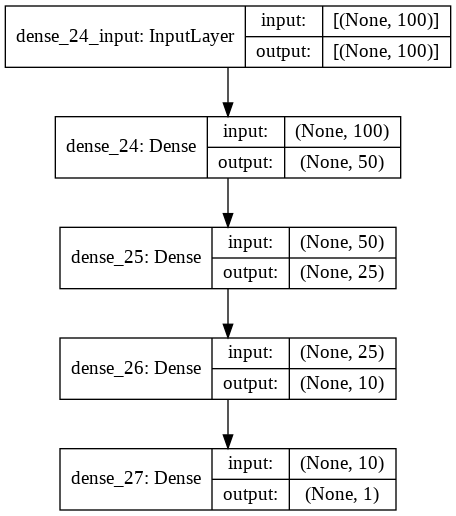

In [36]:
plot_model(model_12, show_shapes=True)

For the Classification Task:
3 Hidden Layers with number of nodes:
* 100 -> 75 -> 75 

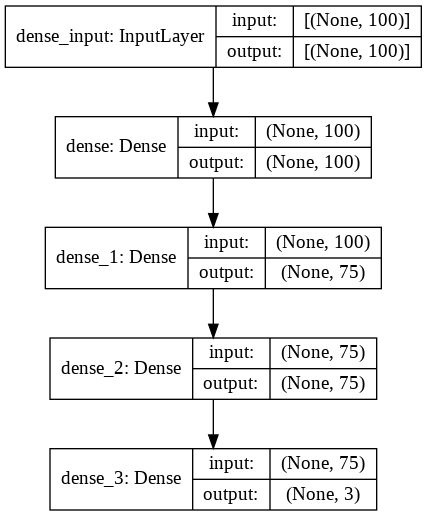

In [37]:
plot_model(cmodel_12, show_shapes=True)